# Olivine Diffusion - 2

(c) Charles Le Losq

## What is the shape of the objective function?

Our initial attempt to fit the synthetic problem did not work. Why?

To answer this question, we can better understand the problem by looking at the shape of the objective function.

First, we load libraries and redefine first the forward model and the synthetic problem.

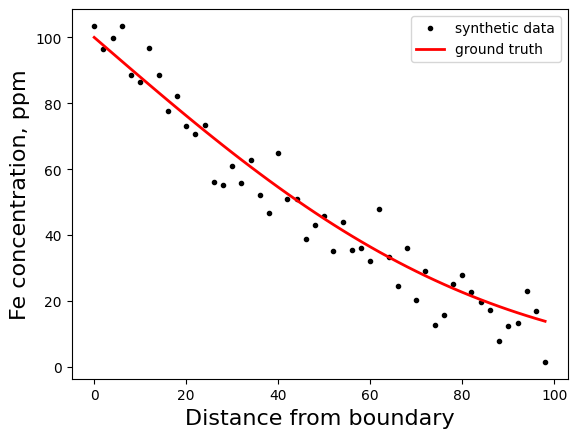

In [51]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import scipy
from scipy.optimize import curve_fit

from scipy.special import erfc

def forward_model(x, D, c0):
    """This is the foward model: solution in 1D of Fick diffusion
    
    Parameters
    ----------
    x : 1d array
        the distance in microns
    D : float
        the diffusion coefficient, in log10 m2 s-1
    c0 : float
        the concentration at the border
        
    Returns
    -------
    c(x) : array
        the array of the concentrations at x
    """
    t = 192.0*3600 # time is defined here
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))

##
# We re-generate the synthetic data
##
x_synthetic = np.arange(0, 100,  2.0) # microns
D_synthetic = -14.5 # log10 m2 s-1
c0_synthetic = 100.0 # ppm

y_synthetic = forward_model(x_synthetic, D_synthetic, c0_synthetic)

noise_synthetic = np.random.randn(len(x_synthetic))*7.0
y_synthetic_noisy = y_synthetic + noise_synthetic
noise_synthetic = np.abs(noise_synthetic)

plt.figure()
plt.plot(x_synthetic,y_synthetic_noisy,"k.",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")

plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend(loc="best")

We now can code the misfit function: the least square criterion 

$misfit = \sum_{i=1}^{n}{(d_i-m_i)^2}$ , eq. 1 

and look at its value as a function of a range of D values for instance:

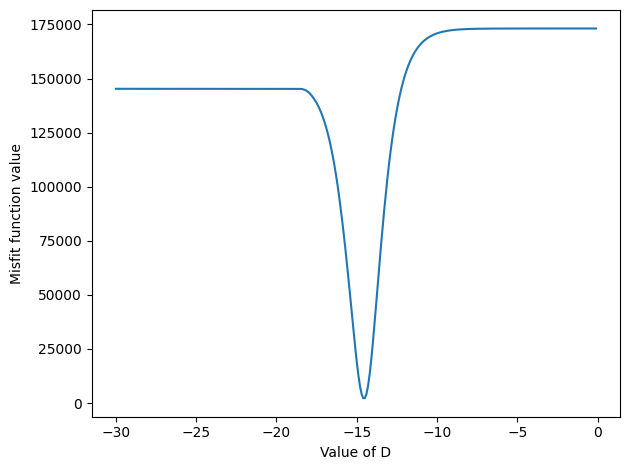

In [52]:
def least_square_criterion(y_measured, y_calculated):
    return np.sum((y_measured-y_calculated)**2)

# this is the values of D
D_range = np.arange(-30.0, 0.0, 0.1)

# this is a list to save the misfit values
misfit_values = np.ones(len(D_range))

for i in range(len(D_range)):
    y_calculated = forward_model(x_synthetic, 
                                 D_range[i], 
                                 c0_synthetic)
    misfit_values[i] = least_square_criterion(y_synthetic_noisy,
                                              y_calculated)

# we now plot things:
plt.plot(D_range, misfit_values)
plt.xlabel("Value of D")
plt.ylabel("Misfit function value")
plt.tight_layout()

If we were using the least absolute deviation criterion as a misfit function, we will have

$misfit = \sum_{i=1}^{n}{|(d_i-m_i)|}$ . eq. 2

the plot will look like


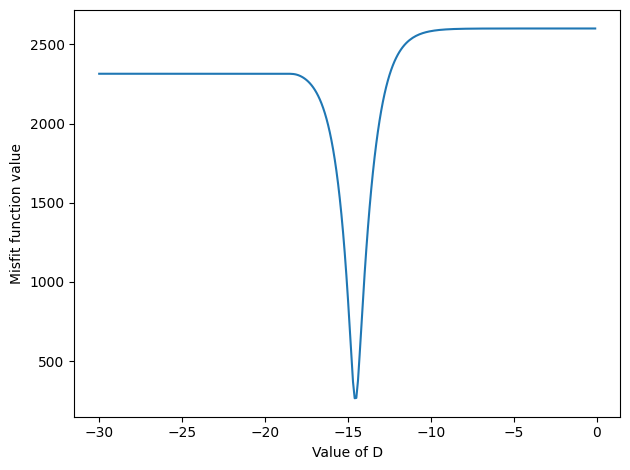

In [53]:
def least_absolute_criterion(y_measured, y_calculated):
    return np.sum(np.abs(y_measured-y_calculated))

misfit_lad_values = np.ones(len(D_range))

for i in range(len(D_range)):
    y_calculated = forward_model(x_synthetic, 
                                 D_range[i], 
                                 c0_synthetic)
    misfit_lad_values[i] = least_absolute_criterion(y_synthetic_noisy,
                                              y_calculated)

# we now plot things:
plt.plot(D_range, misfit_lad_values)
plt.xlabel("Value of D")
plt.ylabel("Misfit function value")
plt.tight_layout()

It looks pretty similar except the shape of the dwell is different. Least absolute deviation is more robust to outliers (see other additional notebook 03_VisualizeOF), but beware that it is not differentiable.

We can also visualize the objective function in 2D (as we have two parameters).

/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_62086/3208040971.py:28: UserWarning: linewidths is ignored by contourf
  curve = ax.contourf(x_of, y_of, LAD_OF, levels=14, linewidths=0.5)


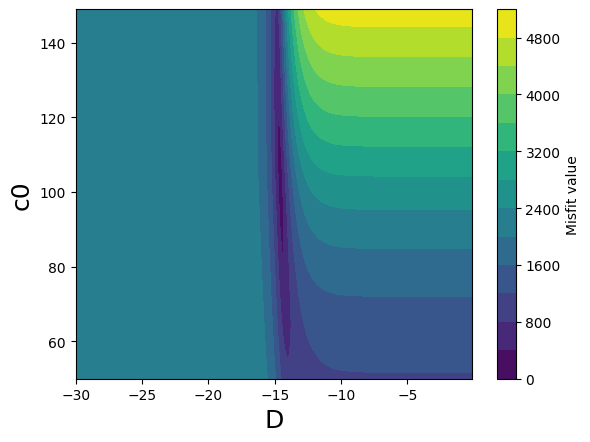

In [54]:
c0_range = np.arange(50, 150.0, 1.0)

# saving the shapes
nb_D = len(D_range)
nb_c0 = len(c0_range)

# and we calculate the objective function for each value, fixing b to it's true value.
LS_OF = np.zeros((nb_D,nb_c0)) # we create a variable to store the least-square objective function values
LAD_OF = np.zeros((nb_D,nb_c0)) # same for LAD
x_of = np.zeros((nb_D,nb_c0)) #
y_of = np.zeros((nb_D,nb_c0)) #
for i in range(len(D_range)):
    for j in range(len(c0_range)):
        y_calculated = forward_model(x_synthetic,D_range[i],c0_range[j])
        LS_OF[i,j] = least_square_criterion(y_synthetic_noisy,y_calculated)
        LAD_OF[i,j] = least_absolute_criterion(y_synthetic_noisy,y_calculated)
        
        x_of[i,:] = D_range[i]
        y_of[:,j] = c0_range[j]

###
# we now do the plot
###
Xi, Yi = np.meshgrid(D_range, c0_range)

fig = plt.figure()
ax = fig.add_subplot(111)
curve = ax.contourf(x_of, y_of, LAD_OF, levels=14, linewidths=0.5)

plt.xlabel("D",fontsize = 18)
plt.ylabel("c0",fontsize = 18)
plt.colorbar(curve, label="Misfit value")

You can see that for our problem, the objective function space looks very weird. It is definitely not a nice 2D Gaussian function for instance (e.g. see 03_VisualizeOF notebook). This is something you need to consider when using available methods to find your best set of parameters.

The most popular methods are gradient-based, meaning they work in the space represented by the figure above to find the position of the dwell. To do that, they calculate the gradient, i.e. the derivatives of the objective function $S(c0, D)$ as a function of the parameters c0 and D, 
$\frac{\partial{S}}{\partial{c0}}$
and
$\frac{\partial{S}}{\partial{D}}$. You then make small moves to iteratively converge toward the lowest position in the above figure.

*Which difficulties do you identify for such an approach?*

- what if several minima exist?
- gradient is very small far from the dwell, may not converge at all... or too slowly.
- what if the objective function is not differentiable?

# Solving difficulties

We will solve the difficulties listed above in three steps:

- #1 - Initialisation of the search algorithm close to the solution (usually it initiate values at 1.0... this may not be appropriate!)
- #2 - Using a large scale algorithm
- #3 - Using a search algorithm that is not gradient-based (e.g. if you want to solve the problem using least absolute deviation)

### #1 - initiate parameters at reasonable values.

First, the simplest solution is to start with reasonable values for c0 and D! `curve_fit` takes a p0 parameter to do so:

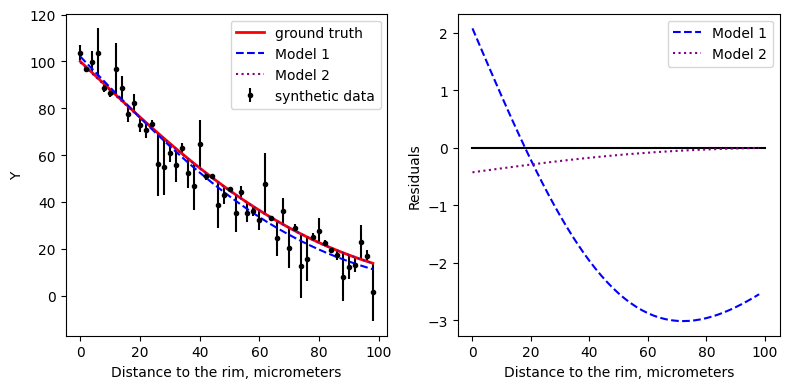

In [55]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 
popt, pcov = curve_fit(forward_model, 
                       x_synthetic, 
                       y_synthetic_noisy,
                       p0 = [-14.0, 80.0]) # here are our starting values
popt2, pcov2 = curve_fit(forward_model, 
                         x_synthetic, 
                         y_synthetic_noisy, 
                         sigma=noise_synthetic, 
                         absolute_sigma=True,
                         p0 = [-14.0, 80.0]) # here are our starting values

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.errorbar(x_synthetic,y_synthetic_noisy,
             yerr=noise_synthetic,
             fmt=".", color="k",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt),"b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2),":",c="purple",label="Model 2")
plt.xlabel("Distance to the rim, micrometers")
plt.ylabel("Y")
plt.legend()

plt.subplot(1,2,2)
plt.plot([0,100],[0,0],"k")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt)-y_synthetic,"b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2)-y_synthetic,":",c="purple",label="Model 2")
plt.ylabel("Residuals")
plt.xlabel("Distance to the rim, micrometers")
plt.legend()

plt.tight_layout()

Ahhh, better! We also note that the residuals are smaller when taking into account for the errors on the data. Seems pretty logic. So if you have error bars, use them! If not, try to estimate the errors that affect your data. This is always important.

### #2 - Use a large-scale algorithms

Some algorithms are made to perform large scale search for parameters, such as *differential evolution* or *particule swarm*. We can try the `differential_evolution` algorithm of scipy.

We need to redefine a Python function that takes the parameters and the forward function argument as an input. In other terms, the `differential_evolution` function in scipy takes a fully integrated objective function as an argument, its API is different compared to the `curve_fit` function.

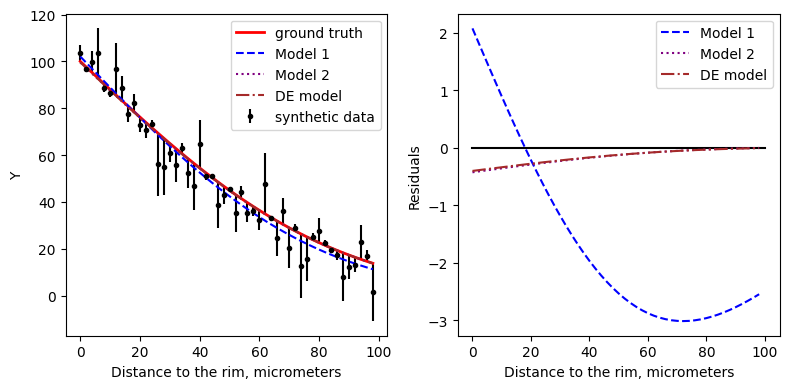

In [56]:
from scipy.optimize import differential_evolution # we import the method here

def least_squares_objective(list_of_parameters, x, y, yerr=1.0):
    """the least square objective function"""
    model_values = forward_model(x, list_of_parameters[0], list_of_parameters[1])
    criterion = np.sum((y-model_values)**2/yerr**2) # ponderated least squares criterion
    return criterion

# we need to define a search space
# in the form of a list, containing sub-mlists of lower and upper bounds for the parameters
search_space = [[-30., 0.], # D bounds
                [0.0, 200.]] #c0 bounds

# the differential_evolution expects that the least_squares_objective
# function takes the parameters as the first argument. 
# Any additional inputs are provided in a tuple via the args argument
# this is pretty standard in scipy
# the minimize() function (actually behind curve_fit) uses the same API
result_LS = differential_evolution(least_squares_objective, # objective function
                                   search_space, # search space (list of [lb, hb] per parameter)
                                   args=(x_synthetic,
                                         y_synthetic_noisy,
                                         noise_synthetic))

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.errorbar(x_synthetic,
             y_synthetic_noisy,
             yerr=noise_synthetic,
             fmt=".", color="k",
             label="synthetic data")
plt.plot(x_synthetic, y_synthetic, 
         "r-", linewidth=2.0, label="ground truth")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt),
         "b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2),
         ":",c="purple",label="Model 2")
plt.plot(x_synthetic,forward_model(x_synthetic, *result_LS.x),
         "-.",c="brown",label="DE model")

plt.xlabel("Distance to the rim, micrometers")
plt.ylabel("Y")
plt.legend()

plt.subplot(1,2,2)
plt.plot([0,100],[0,0],"k")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt)-y_synthetic,
         "b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2)-y_synthetic,
         ":",c="purple",label="Model 2")
plt.plot(x_synthetic,forward_model(x_synthetic, *result_LS.x)-y_synthetic,
         "-.",c="brown",label="DE model")
plt.ylabel("Residuals")
plt.xlabel("Distance to the rim, micrometers")
plt.legend()

plt.tight_layout()

### #3 -- Use a different objective function

and a non-gradient base algorithm.

Actually we already did that, `differential_evolution` is not based on the calculation of the gradient. It is an evolutionary algorithm. For details, see the [Wikipedia page for instance](https://en.wikipedia.org/wiki/Differential_evolution)

Other algorithms are provided by scipy.minimize(), see help [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

For simplicity, we will re-use the `differential_evolution` algorithm below to compare results from using the least square or least absolute deviation objective functions.

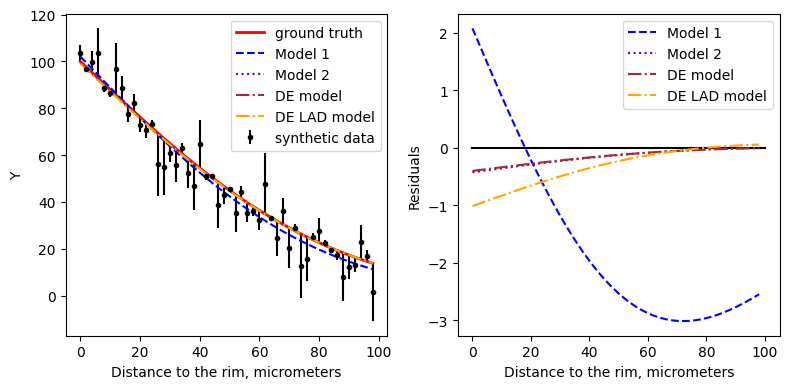

In [57]:
def least_absolute_objective(list_of_parameters, x, y, yerr=1.0):
    """the least absolute deviation objective function"""
    model_values = forward_model(x, list_of_parameters[0], list_of_parameters[1])
    criterion = np.sum(np.abs((y-model_values)/yerr))
    return criterion

# the fit using least absolute deviation
result_LAD = differential_evolution(least_absolute_objective,
                                   search_space, 
                                   args=(x_synthetic,
                                         y_synthetic_noisy,
                                         noise_synthetic))

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.errorbar(x_synthetic,y_synthetic_noisy,
             yerr=noise_synthetic,
             fmt=".", color="k",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt),"b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2),":",c="purple",label="Model 2")
plt.plot(x_synthetic,forward_model(x_synthetic, *result_LS.x),"-.",c="brown",label="DE model")
plt.plot(x_synthetic,forward_model(x_synthetic, *result_LAD.x),"-.",c="orange",label="DE LAD model")

plt.xlabel("Distance to the rim, micrometers")
plt.ylabel("Y")
plt.legend()

plt.subplot(1,2,2)
plt.plot([0,100],[0,0],"k")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt)-y_synthetic,"b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2)-y_synthetic,":",c="purple",label="Model 2")
plt.plot(x_synthetic,forward_model(x_synthetic, *result_LS.x)-y_synthetic,"-.",c="brown",label="DE model")
plt.plot(x_synthetic,forward_model(x_synthetic, *result_LAD.x)-y_synthetic,"-.",c="orange",label="DE LAD model")

plt.ylabel("Residuals")
plt.xlabel("Distance to the rim, micrometers")
plt.legend()

plt.tight_layout()

### Conclusion

Results are slightly different. We observed the shape of the objective space,
compared several methods readily available in `scipy`, took into account of the errors affecting the data in the fit... 

Three questions are now important:
- What are the errors on predicted parameters?
- Could we provide estimates of those parameters *à priori*?
- Could we do better? Get closer to the truth?

To answer those questions, let's move to the next notebook, OlivineDiffusion_3 !